### Here is a quick guide / readme for this code suite.

Let's import our necessary libraries. Some code I have written will be stored in the modules folder.

* correspondences.py

Code that relates to generating, processing, or visualizing correspondences.

* jacobian.py

Code that relates to computing or visualizing the Jacobian matrix and the determinants

* laplacian.py

Code that relates to computing the Laplacian matrix.

In [5]:
#%pip install SimpleITK

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 30.2 MB 2.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import standard libraries
from functools import partial

# Import some third-party libraries that we may need
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from scipy.ndimage import geometric_transform
from scipy.sparse.linalg import lgmres

In [6]:
# Import our libraries
import modules.correspondences as correspondences
import modules.jacobian as jacobian
import modules.laplacian as laplacian

Correspondence points and output data from sample mouse registration applications from our runs are stored in the data folder.

* base_unique_correspondences

Contains a sample run from our registration algorithm with no additional processing done to the correspondences.

* corrected_correspondences_count_touching

Contains a sample run from our registration algorithm with intersecting correspondences removed. 


### Each folder contains several files of interest:

* mpoints.npy

A pickled numpy array of the moving correspondence points

* fpoints.npy

A pickled numpy array of the fixed correspondence points

* registered_output/deformation3d.npy

A pickled numpy array of the output deformation field from solving the Laplacian.

* registered_output/elastixRefined.nii.gz

A NIFTI file of the brain volume that the deformation field transforms.


In [7]:
import numpy as np

# Let's try loading in a set of example moving and fixed correspondence points
mpoints_path = "data/base_unique_correspondences/mpoints.npy"
fpoints_path = "data/base_unique_correspondences/fpoints.npy"

mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

print("Moving points shape: ", mpoints.shape)
print("Fixed points shape: ", fpoints.shape)

print("\nFirst 5 moving points:\n", mpoints[:5])
print("\nFirst 5 fixed points:\n", fpoints[:5])

Moving points shape:  (389967, 3)
Fixed points shape:  (389967, 3)

First 5 moving points:
 [[  1.  73. 216.]
 [  1.  74. 216.]
 [  1.  67. 170.]
 [  1.  68. 170.]
 [  1.  69. 171.]]

First 5 fixed points:
 [[  1. 176. 230.]
 [  1. 178. 231.]
 [  1. 194. 174.]
 [  1. 196. 174.]
 [  1. 201. 178.]]


In [8]:
# Now let's load in the deformation field
deformation_field_path = "data/base_unique_correspondences/registered_output/deformation3d.npy"
deformation_field = np.load(deformation_field_path)

print("Deformation field shape: ", deformation_field.shape)
print("Example displacement vector (z, y, x) at (10, 200, 200):", deformation_field[:, 10, 200, 200])

Deformation field shape:  (3, 528, 320, 456)
Example displacement vector (z, y, x) at (10, 200, 200): [  0.         -27.56649611   0.34683496]


SITK deformation shape: (528, 320, 456, 3)
Minimum Jacobian determinant value: -187.80903954186755
Maximum Jacobian determinant value: 172.8716521528275
Number of negative Jacobian determinants: 215388
Number of zero Jacobian determinants: 0
Number of positive Jacobian determinants: 76830372
Shape of Jacobian determinant: (528, 320, 456)


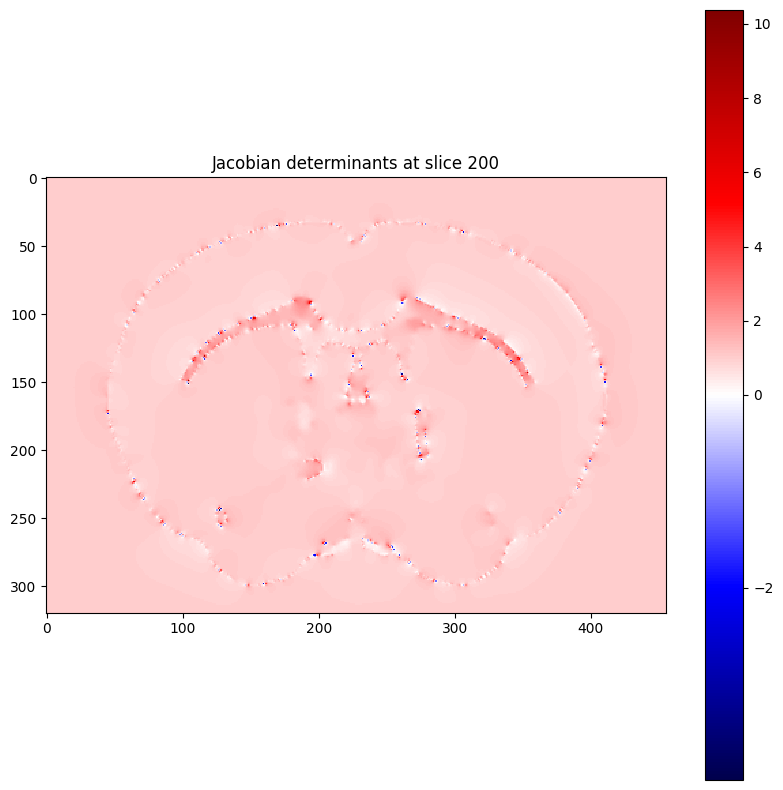

In [17]:
import matplotlib.colors as mcolors

# Let's try computing the Jacobian determinant of the deformation field
jacobian_det = jacobian.sitk_jacobian_determinant(deformation_field)
print("Minimum Jacobian determinant value:", np.min(jacobian_det))
print("Maximum Jacobian determinant value:", np.max(jacobian_det))
print("Number of negative Jacobian determinants:", np.sum(jacobian_det < 0))
print("Number of zero Jacobian determinants:", np.sum(jacobian_det == 0))
print("Number of positive Jacobian determinants:", np.sum(jacobian_det > 0))
print(f'Shape of Jacobian determinant: {jacobian_det.shape}')

# Create a custom colormap with white at zero and plot it
curr_slice = 200
norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_det[curr_slice].min(), -1), vcenter=0, vmax=jacobian_det[curr_slice].max())
plt.figure(figsize=(10, 10))
plt.imshow(jacobian_det[curr_slice], cmap='seismic', norm=norm, interpolation='nearest')
plt.colorbar()
plt.title("Jacobian determinants at slice 200")
plt.show()

Let's try building a Laplacian matrix and solving it. 

In [ ]:
# Create some example correspondence points
msample = np.array([
    [1, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
# sliceToSlice3DLaplacian creates a Laplacian matrix from a sample set of correspondence points
# The Laplacian matrix is used to compute the deformation field
# The function returns the deformation field, Laplacian matrix, 
# and right hand sides of the Laplacian equation used to compute the deformation field
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Let's solve for the x-displacement
# Note these are just examples to show how this works. 
# Much of this computation is already done in the functions. 
# Please check the functions for more details. 
dx = lgmres(A, Xd, tol = 1e-2)[0]
print("dx shape:", dx.shape)
print("dx:", dx)
print()

# Show values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)


fdata.shape (1, 5, 5)
Building data for Laplacian Sparse Matrix A
Creating Laplacian Sparse Matrix A
Computing dz
dz calculated in 3.7093210220336914s
Computing dy
dy calculated in 3.709383726119995s
Computing dx
dx calculated in 3.710057020187378s
dx shape: (25,)
dx: [ 0.62085992 -0.05524104 -1.05900262 -2.06978331 -2.15755896  1.29410218  0.26982576 -1.05413002 -2.99989838 -2.24480832  2.99989838  0.90370138 -0.42470534 -1.44454148 -1.57424583  1.64286058  0.77307759 -0.104447   -0.77654146 -1.03880112  1.1453668   0.64339945  0.00813835 -0.51389401 -0.77213651]

A shape: (25, 25)
[[ 2. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

/tmp/ipykernel_2055467/2616268036.py:22: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dx = lgmres(A, Xd, tol = 1e-2)[0]


Volume shape:  (528, 320, 456)


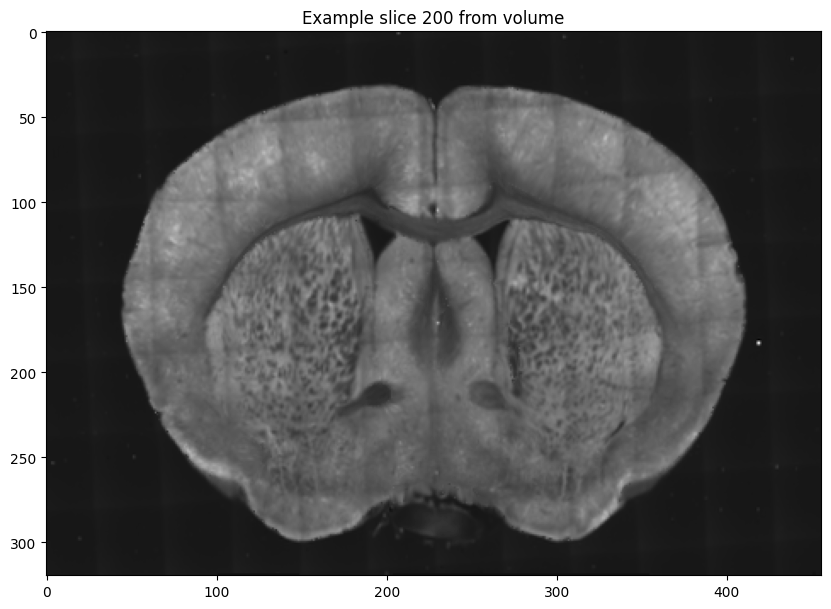

In [25]:
import matplotlib.pyplot as plt
import nibabel as nib

# Next, let's load in the image volume.
volume_path = "data/base_unique_correspondences/registered_output/elastixRefined.nii.gz"

volume = nib.load(volume_path).get_fdata()

print("Volume shape: ", volume.shape)

# Let's plot an example slice from the volume
plt.figure(figsize=(10, 10))
plt.imshow(volume[200, :, :], cmap="gray")
plt.title("Example slice 200 from volume")
plt.show()

Additionally, another folder is provided, the CCF_DATA folder. This folder contains the image volumes that are used as templates in registration. elastixRefined.nii.gz in the data folders are made to fit to these templates. These templates are generated and provided by the 

The CCF_DATA folder has two files of interest:

* annotation_25.nii.gz

An image volume that contains integer labels for anatomical portions of the Allen Mouse CCF brain.

* average_template_25.nii.gz

An image volume that contains averaged brain intensities across a set of mouse brains.

CCF annotation shape:  (528, 320, 456)
CCF template shape:  (528, 320, 456)


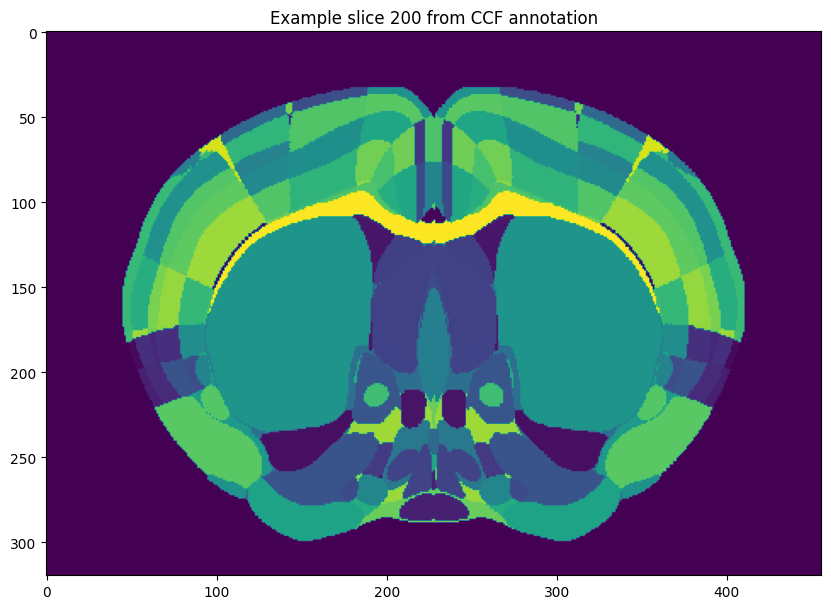

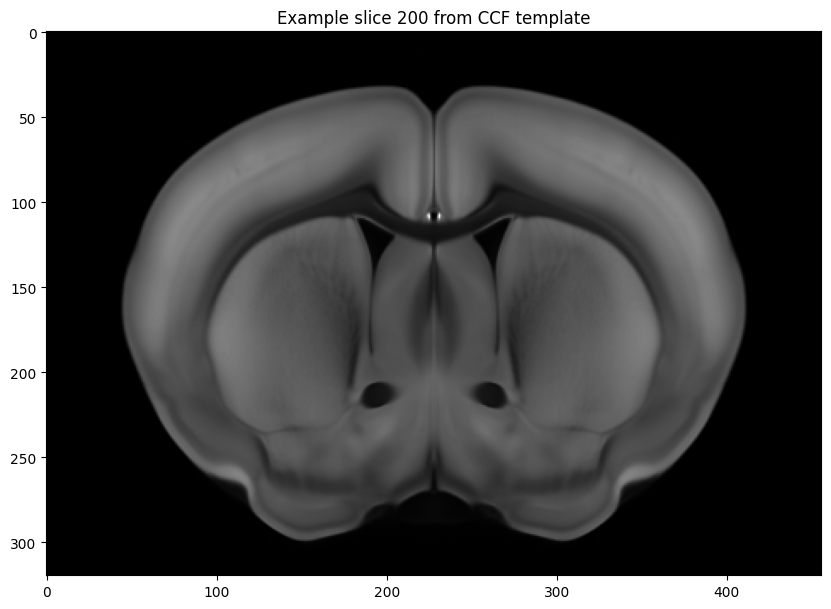

In [19]:
ccf_annotation_path = "data/CCF_DATA/annotation_25.nii.gz"
ccf_template_path = "data/CCF_DATA/average_template_25.nii.gz"

ccf_annotation = nib.load(ccf_annotation_path).get_fdata()
ccf_template = nib.load(ccf_template_path).get_fdata()

print("CCF annotation shape: ", ccf_annotation.shape)
print("CCF template shape: ", ccf_template.shape)

# Let's plot an example slice from the annotation
plt.figure(figsize=(10, 10))
plt.imshow(ccf_annotation[200, :, :])
plt.title("Example slice 200 from CCF annotation")
plt.show()

# Let's plot an example slice from the template
plt.figure(figsize=(10, 10))
plt.imshow(ccf_template[200, :, :], cmap="gray")
plt.title("Example slice 200 from CCF template")
plt.show()

Try applying the deformation field to the volume image data.

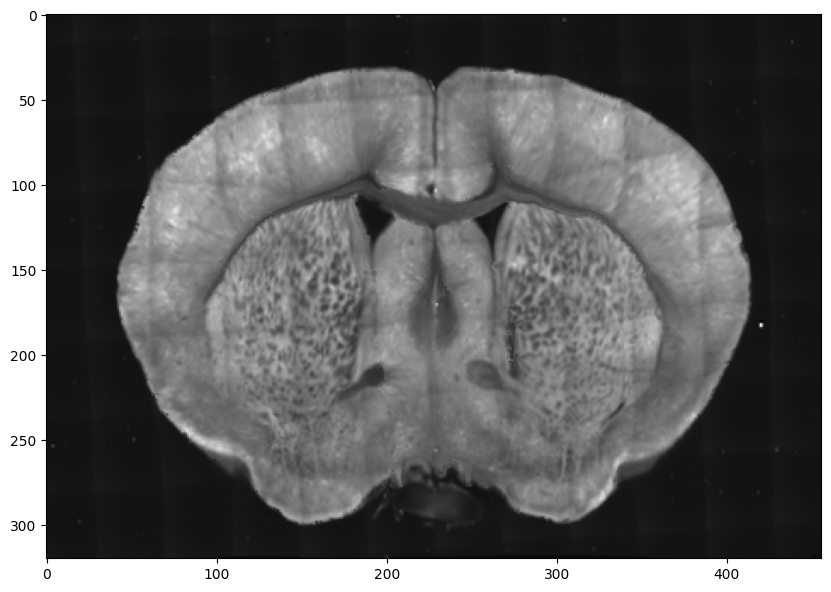

In [ ]:
def shift3Dfunc(point, dx, dy, dz):
    px = point[0] + dx[point[0], point[1],  point[2]]
    py = point[1] + dy[point[0], point[1],  point[2]]
    pz = point[2] + dz[point[0], point[1],  point[2]]
    if(px<0 or px> dx.shape[0]):
        return (point[0], point[1], point[2])
    if(py<0 or py> dx.shape[1]):
        return (point[0], point[1], point[2])
    if(pz<0 or pz> dx.shape[2]):
        return (point[0], point[1], point[2])
    return (px, py, pz)

transformedData = geometric_transform(volume, partial(shift3Dfunc, 
                                                      dx=deformation_field[0], 
                                                      dy=deformation_field[1], 
                                                      dz=deformation_field[2]))

plt.figure(figsize=(10, 10))
plt.imshow(transformedData[200, :, :], cmap="gray")
plt.title("Transformed section 200")
plt.show()